In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import mne
import numpy as np
import pandas as pd
from mne.time_frequency import tfr_morlet
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%config InlineBackend.figure_formats = ["svg"]
mne.set_config("MNE_USE_CUDA", "true")

In [3]:
# set path
# change bids_path to your BIDS path
bids_path = os.path.join("F:", os.sep, "EGI_DATA", "EGI_BIDS")
data_path = os.path.join(bids_path, "derivatives", "eeglab-preproc")
figure_path = os.path.join("..", "figures")
# set task name
foodtask = "foodchoice"
wordtask = "wordchoice"
imagetask = "imagechoice"

# epoch windows
tmin, tmax = -0.2, 0.8
random_state = 97
# exclude subjects id
exclude_subjects = [1, 5, 19, 28]
# reserved subjects
subjects = [f"sub-{str(i).zfill(2)}" for i in range(1, 31) if i not in exclude_subjects]

## Load data

In [4]:
# get montage
montage = mne.channels.make_standard_montage("GSN-HydroCel-129")
montage.ch_names[-1] = "E129"

### Get epochs

In [5]:
# extract epochs for subject
def get_epoch(task, sub, time_window=(tmin, tmax)):
    # read .set eeg
    eeg_path = os.path.join(data_path, sub, f"{sub}_task-{task}_eeg.set")
    raw = mne.io.read_raw_eeglab(eeg_path, verbose=40)
    raw.set_montage(montage)
    # mark boundary(from eeglab) as bad(for mne)
    raw.annotations.description[raw.annotations.description == "boundary"] = "bad"
    # for foodchoice task
    if task == foodtask:
        # "0400": stim mark, "0500": response (left) mark, "0501": response (right) mark
        for i in range(len(raw.annotations.description) - 1):
            # separate simt mark based on the response (left vs. right)
            # left -> "0600"
            if raw.annotations.description[i] == "0400" and raw.annotations.description[i + 1] == "0500":
                raw.annotations.description[i] = "0600"
            # right -> "0601"
            elif raw.annotations.description[i] == "0400" and raw.annotations.description[i + 1] == "0501":
                raw.annotations.description[i] = "0601"
            else:
                continue
    # renmae marks, only correct trials reserved after preprocessing
    events, mark2idx = mne.events_from_annotations(raw)
    task_type = task[:-6]
    if task == foodtask:
        # foodchoice
        mark2event = {"0600": f"{task_type}/left",
                    "0601": f"{task_type}/right"}
    else:
        # wordchoice/imagechoice task
        mark2event = {"0400": f"{task_type}/animate/left",
                    "0401": f"{task_type}/animate/right",
                    "0402": f"{task_type}/inanimate/right",
                    "0403": f"{task_type}/inanimate/left"}
    event_dict = {event: mark2idx[mark] for mark, event in mark2event.items()}
    # return epochs
    return mne.Epochs(raw, events, event_dict, time_window[0], time_window[1], preload=True)

In [ ]:
# get epochs
task_epochs = {task: [] for task in [foodtask, wordtask, imagetask]}
for task, epochs in task_epochs.items():
    for sub in subjects:
        epochs.append(get_epoch(task, sub))

In [7]:
# make sure subject correspond to the epochs
assert len(subjects) == len(task_epochs[foodtask])

### Evokeds and TFA

In [8]:
# TFR setup
# define frequencies of interest (log-spaced)
freqs = np.logspace(*np.log10([1, 30]), num=30)
# different number of cycle per frequency
n_cycles = freqs / 2.

In [ ]:
# conditions for different tasks
conds = {
    foodtask: ["all", "left", "right"],
    wordtask: ["all", "animate", "inanimate", "left", "right"],
    imagetask: ["all", "animate", "inanimate", "left", "right"]
}
# evokeds for each subject/conditions
sub_evokeds = {task: {cond: [] for cond in conds[task]} for task in task_epochs.keys()}
# combined evokeds
group_evokeds = {}
# TFR power fo each subject/conditions
group_powers = {task: {cond: [] for cond in conds[task]} for task in task_epochs.keys()}
# epochs of each task
for task, sub_epochs in task_epochs.items():
    # different conditions
    for cond in conds[task]:
        # epochs of all subjects
        for epoch in sub_epochs:
            cond_epoch = epoch if cond == "all" else epoch[cond]
            # evoked
            sub_evokeds[task][cond].append(cond_epoch.average())
            # TFR
            power, _ = tfr_morlet(cond_epoch, freqs=freqs, n_cycles=n_cycles, use_fft=True, decim=3, n_jobs=16)
            group_powers[task][cond].append(power)
    # group level evokeds for different tasks and conditions
    group_evokeds[task] = {cond: mne.combine_evoked(evokeds, "nave") for cond, evokeds in sub_evokeds[task].items()}

### Raw epoch example (Fig. 3c)

Opening epochs-browser...


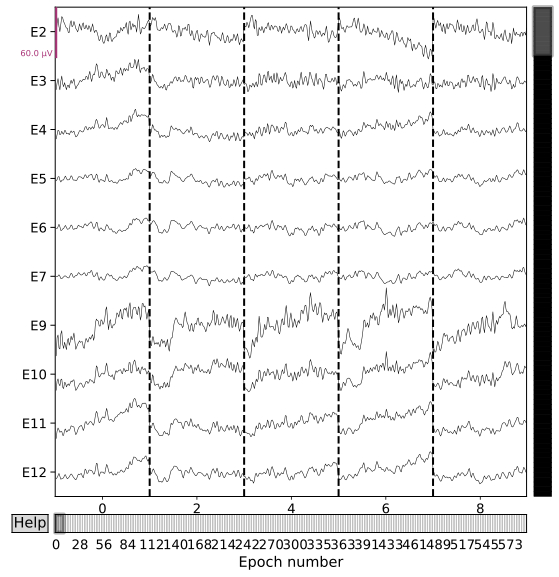

In [107]:
task_epochs[wordtask][6].plot(scalings=3e-5, n_epochs=8, n_channels=15)
# plt.savefig(os.path.join(figure_path, "raw_epoch.svg"), bbox_inches="tight")
plt.show()

## ERP

### foodChoice (Fig. 5 left)

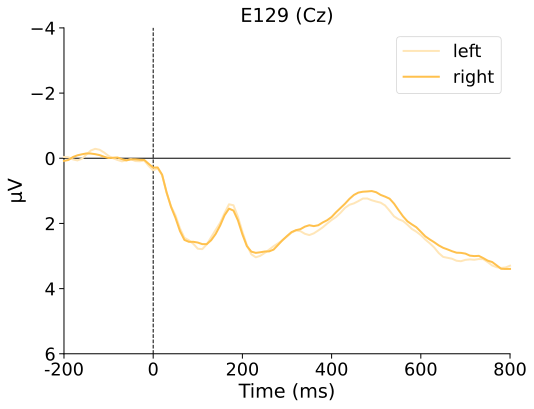

In [175]:
sns.set_context("paper", font_scale=2)
viz_evks = {
    "left": group_evokeds[foodtask]["left"],
    "right": group_evokeds[foodtask]["right"],
}
plot_config = dict(
    picks=["E129"],
    legend="upper right",
    ylim=dict(eeg=[-4, 6]),
    colors=dict(left="#FFE6B8", right="#FFC14D"),
    styles=dict(left=dict(linewidth=2), right=dict(linewidth=2)),
    invert_y=True,
    show_sensors=False,
    title="E129 (Cz)",
    show=False
)
fig = mne.viz.plot_compare_evokeds(viz_evks, **plot_config)
# xticklabels: s to ms
xlabels = [int(x * 1000) for x in fig[0].axes[0].get_xticks()]
fig[0].axes[0].set_xticklabels(xlabels)
# xlabel
fig[0].axes[0].set_xlabel("Time (ms)")
# legend
# fig[0].legend(loc="upper right", frameon=False)
fig[0].savefig(os.path.join(figure_path, foodtask, "E129_ERP.svg"), bbox_inches="tight")
plt.show()

### imageChoice (Fig. 5 center)

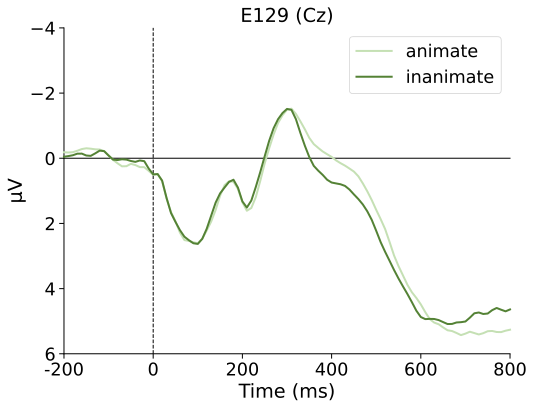

In [173]:
sns.set_context("paper", font_scale=2)
viz_evks = {
    "animate": group_evokeds[imagetask]["animate"],
    "inanimate": group_evokeds[imagetask]["inanimate"]
}
plot_config = dict(
    picks=["E129"],
    legend="upper right",
    ylim=dict(eeg=[-4, 6]),
    colors=dict(animate="#C5E0B4", inanimate="#548235"),
    styles=dict(animate=dict(linewidth=2), inanimate=dict(linewidth=2)),
    invert_y=True,
    show_sensors=False,
    title="E129 (Cz)",
    show=False
)
fig = mne.viz.plot_compare_evokeds(viz_evks, **plot_config)
# xticklabels: s to ms
xlabels = [int(x * 1000) for x in fig[0].axes[0].get_xticks()]
fig[0].axes[0].set_xticklabels(xlabels)
# xlabel
fig[0].axes[0].set_xlabel("Time (ms)")
fig[0].savefig(os.path.join(figure_path, imagetask, "E129_ERP.svg"), bbox_inches="tight")
plt.show()

### wordChoice (Fig. 5 right)

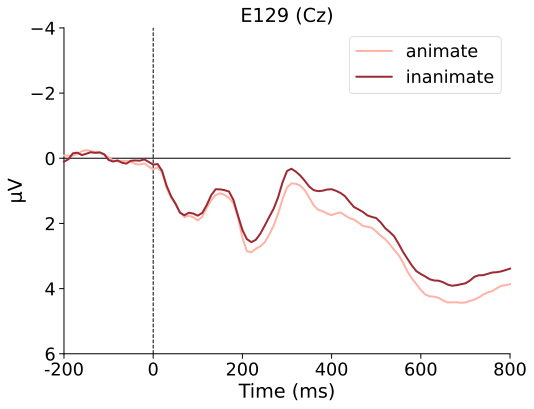

In [ ]:
sns.set_context("paper", font_scale=2)
viz_evks = {
    "animate": group_evokeds[wordtask]["animate"],
    "inanimate": group_evokeds[wordtask]["inanimate"]
}
plot_config = dict(
    picks=["E129"],
    legend="upper right",
    ylim=dict(eeg=[-4, 6]),
    colors=dict(animate="#FFB3A7", inanimate="#9D2933"),
    styles=dict(animate=dict(linewidth=2), inanimate=dict(linewidth=2)),
    invert_y=True,
    show_sensors=False,
    title="E129 (Cz)",
    show=False
)
fig = mne.viz.plot_compare_evokeds(viz_evks, **plot_config)
# xticklabels: s to ms
xlabels = [int(x * 1000) for x in fig[0].axes[0].get_xticks()]
fig[0].axes[0].set_xticklabels(xlabels)
# xlabel
fig[0].axes[0].set_xlabel("Time (ms)")
fig[0].savefig(os.path.join(figure_path, wordtask, "E129_ERP.svg"), bbox_inches="tight")
plt.show()

### image/word (Extra figures, not used in the paper)

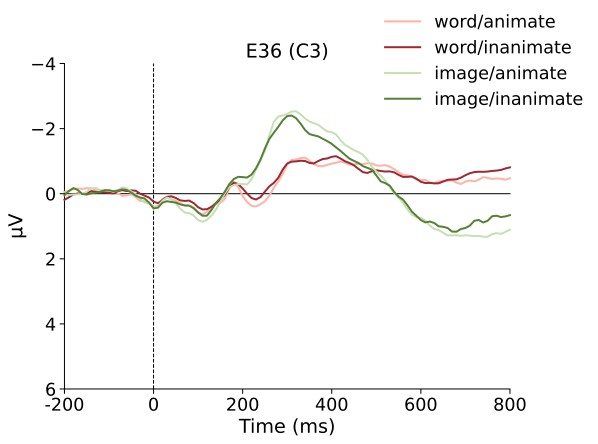

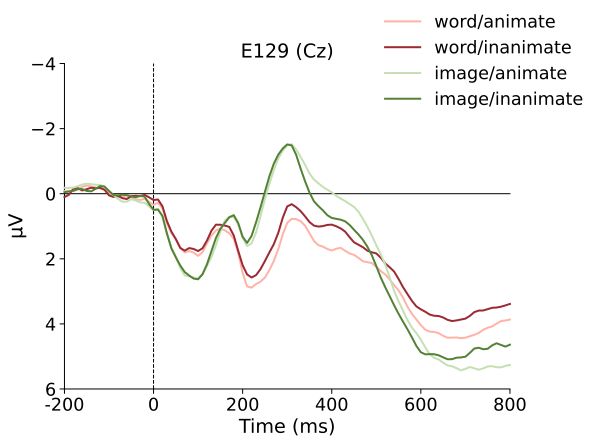

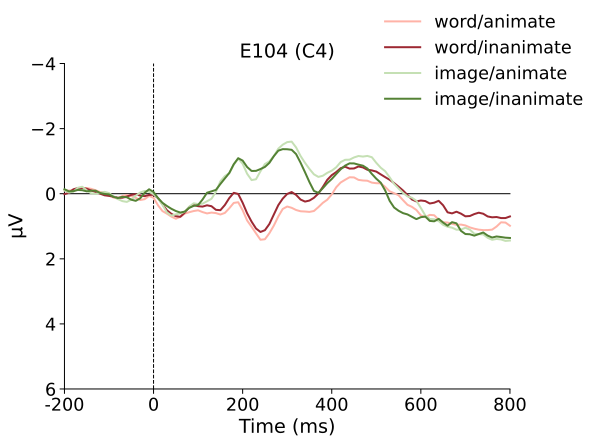

In [240]:
sns.set_context("paper", font_scale=2)
viz_evks = {
    "word/animate": group_evokeds[wordtask]["animate"],
    "word/inanimate": group_evokeds[wordtask]["inanimate"],
    "image/animate": group_evokeds[imagetask]["animate"],
    "image/inanimate": group_evokeds[imagetask]["inanimate"]
}
for ch, title in zip(["E36", "E129", "E104"], ["E36 (C3)", "E129 (Cz)", "E104 (C4)"]):
    plot_config = dict(
        picks=[ch],
        legend="upper right",
        ylim=dict(eeg=[-4, 6]),
        colors={"word/animate": "#FFB3A7",
            "word/inanimate": "#9D2933",
            "image/animate": "#C5E0B4",
            "image/inanimate": "#548235"},
        styles={"word/animate": {"linewidth": 2},
            "word/inanimate": {"linewidth": 2},
            "image/animate": {"linewidth": 2},
            "image/inanimate": {"linewidth": 2}},
        invert_y=True,
        show_sensors=False,
        title=title,
        show=False
    )
    fig = mne.viz.plot_compare_evokeds(viz_evks, **plot_config)
    # xticklabels: s to ms
    xlabels = [int(x * 1000) for x in fig[0].axes[0].get_xticks()]
    fig[0].axes[0].set_xticklabels(xlabels)
    # xlabel
    fig[0].axes[0].set_xlabel("Time (ms)")
    fig[0].axes[0].legend(loc="upper right", bbox_to_anchor=(1.2, 1.2))
    fig[0].savefig(os.path.join(figure_path, f"image_word_{ch}_ERP.svg"), bbox_inches="tight")
    plt.show()

## Time-Frequency Analysis (Fig. 6)

### foodChoice

Identifying common channels ...
Applying baseline correction (mode: logratio)


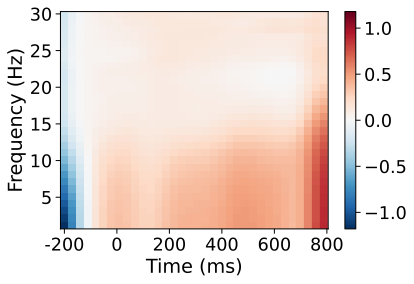

Identifying common channels ...
Applying baseline correction (mode: logratio)


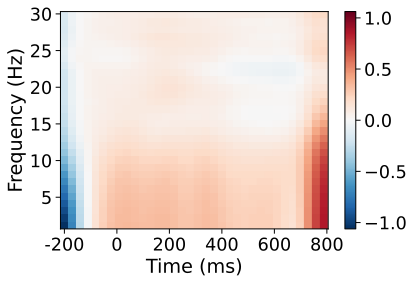

Identifying common channels ...
Applying baseline correction (mode: logratio)


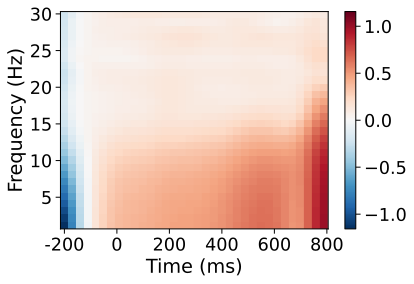

In [185]:
sns.set_context("paper", font_scale=2)
for ch in ["E36", "E129", "E104"]:
    fig = mne.grand_average(group_powers[foodtask]["all"]).plot([ch], baseline=(None, 0), mode="logratio", title="", yscale="linear", show=False)
    # xticklabels: s to ms
    fig[0].axes[0].set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8])
    xlabels = [int(x * 1000) for x in fig[0].axes[0].get_xticks()]
    fig[0].axes[0].set_xticklabels(xlabels)
    # xlabel
    fig[0].axes[0].set_xlabel("Time (ms)")
    fig[0].savefig(os.path.join(figure_path, foodtask, f"{ch}_TFR.svg"), bbox_inches="tight")
    plt.show()

### wordChoice

Identifying common channels ...
Applying baseline correction (mode: logratio)


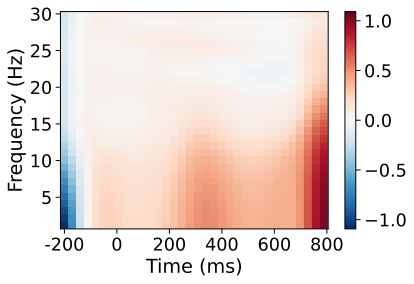

Identifying common channels ...
Applying baseline correction (mode: logratio)


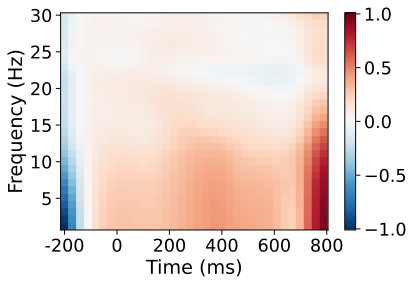

Identifying common channels ...
Applying baseline correction (mode: logratio)


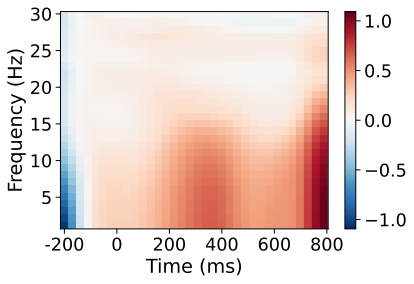

In [187]:
sns.set_context("paper", font_scale=2)
for ch in ["E36", "E129", "E104"]:
    fig = mne.grand_average(group_powers[wordtask]["all"]).plot([ch], baseline=(None, 0), mode="logratio", title="", yscale="linear", show=False)
    # xticklabels: s to ms
    fig[0].axes[0].set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8])
    xlabels = [int(x * 1000) for x in fig[0].axes[0].get_xticks()]
    fig[0].axes[0].set_xticklabels(xlabels)
    # xlabel
    fig[0].axes[0].set_xlabel("Time (ms)")
    fig[0].savefig(os.path.join(figure_path, wordtask, f"{ch}_TFR.svg"), bbox_inches="tight")
    plt.show()

### imageChoice

Identifying common channels ...
Applying baseline correction (mode: logratio)


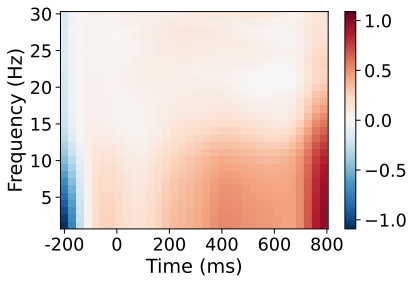

Identifying common channels ...
Applying baseline correction (mode: logratio)


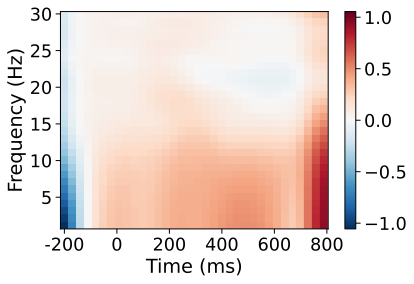

Identifying common channels ...
Applying baseline correction (mode: logratio)


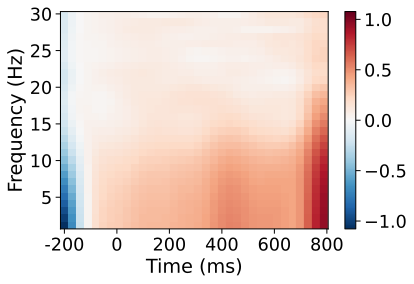

In [188]:
sns.set_context("paper", font_scale=2)
for ch in ["E36", "E129", "E104"]:
    fig = mne.grand_average(group_powers[imagetask]["all"]).plot([ch], baseline=(None, 0), mode="logratio", title="", yscale="linear", show=False)
    # xticklabels: s to ms
    fig[0].axes[0].set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8])
    xlabels = [int(x * 1000) for x in fig[0].axes[0].get_xticks()]
    fig[0].axes[0].set_xticklabels(xlabels)
    # xlabel
    fig[0].axes[0].set_xlabel("Time (ms)")
    fig[0].savefig(os.path.join(figure_path, imagetask, f"{ch}_TFR.svg"), bbox_inches="tight")
    plt.show()

## Topology (Fig. 7)

### food/word/image Choice

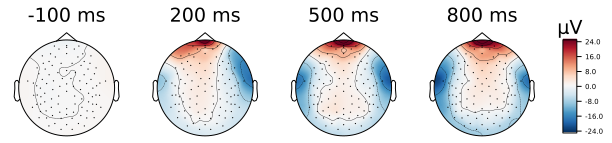

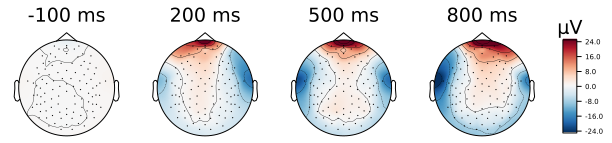

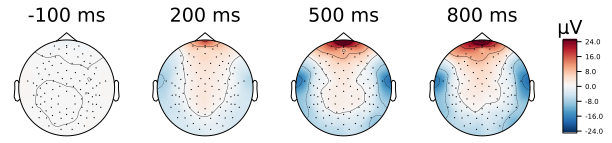

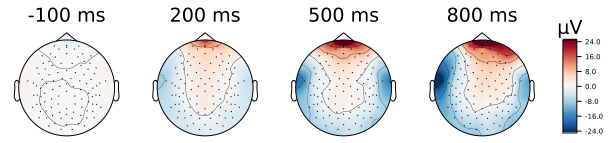

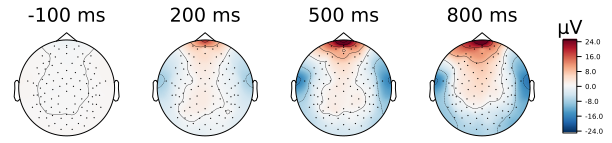

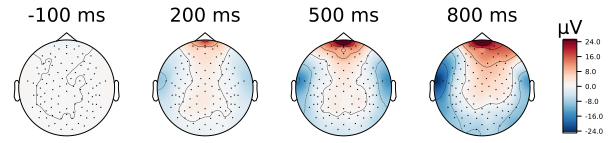

In [242]:
sns.set_context("paper", font_scale=2)
for task, evokeds in group_evokeds.items():
    for cond in ["left", "right"]:
        fig = evokeds[cond].plot_topomap(times=[-0.1, 0.2, 0.5, 0.8], time_unit="ms", size=1.3, title="", vmin=-25, vmax=25)
        fig.savefig(os.path.join(figure_path, task,  f"{cond}_topomap.svg"), bbox_inches="tight")

## MVPA

In [193]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from mne.decoding import (Scaler, cross_val_multiscore, Vectorizer)

In [194]:
def mvpa(epochs, condition):
    epochs.load_data()
    X = np.vstack([epochs[condition[0]].get_data(), epochs[condition[1]].get_data()])  # EEG signals: n_epochs, n_meg_channels, n_times
    y = np.hstack([[0] * len(epochs[condition[0]]), [1] * len(epochs[condition[1]])])  # target: left vs. right
    # classification
    # Uses all sensors and time points as separate classification features, so the resulting filters used are spatio-temporal
    clf = make_pipeline(Scaler(epochs.info), Vectorizer(), SVC())
    scores = cross_val_multiscore(clf, X, y, scoring="accuracy", cv=10, n_jobs=10)
    # Mean scores across cross-validation splits
    score = np.mean(scores, axis=0)
    print(f"Spatio-temporal acc: {100 * score:.1f}%")
    return score

In [ ]:
## -0.2s to 1.8s
# get epochs (with longer time windows since mean RTs are larger than 1200ms)
mvpa_task_epochs = {task: [] for task in [foodtask, wordtask, imagetask]}
for task, epochs in mvpa_task_epochs.items():
    for sub in subjects:
        epochs.append(get_epoch(task, sub, (-0.2, 1.8)))

In [ ]:
mvpa_scores = {task: [] for task in mvpa_task_epochs.keys()}
for task, sub_epochs in mvpa_task_epochs.items():
    for epochs in sub_epochs:
        mvpa_scores[task].append(mvpa(epochs, ["left", "right"]))

foodchoice: mean=0.6704956491346182, std=0.07602591635633121
wordchoice: mean=0.7339859740267423, std=0.09209038102975266
imagechoice: mean=0.773820071412909, std=0.09814286042864552


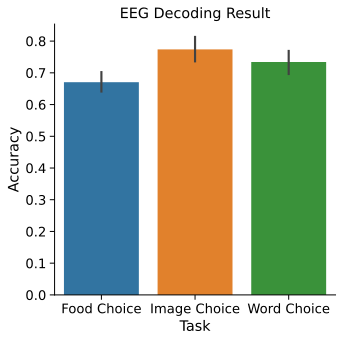

In [241]:
for task, scores in mvpa_scores.items():
    print(f"{task}: mean={np.array(scores).mean()}, std={np.array(scores).std()}")
# plot
sns.set_context("paper", font_scale=1.5)
df = pd.DataFrame({"Food Choice": mvpa_scores[foodtask], "Image Choice": mvpa_scores[imagetask], "Word Choice": mvpa_scores[wordtask]})
viz_df = pd.melt(df, value_vars=df.columns, var_name="Task", value_name="Accuracy")
sns.catplot(kind="bar", data=viz_df, x="Task", y="Accuracy")
plt.title("EEG Decoding Result")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.savefig(os.path.join(figure_path, "mvpa.svg"), bbox_inches="tight")